In [1]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from scipy import signal
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import normalize, StandardScaler
from itertools import combinations
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
import pickle

from multiprocessing import Pool
plt.style.use('seaborn-whitegrid')

# EEG data

In [2]:
def load_data():
    path, folders, filenames = next(walk('./data'))

    filenames.remove('11-audio.csv')
    filenames.remove('11-image.csv')

    filenames.remove('36-audio.csv')
    filenames.remove('36-image.csv')

    path = './data'
    columns = {'Unnamed: 1':'Fp1',
            'Unnamed: 2':'Fp2',
            'Unnamed: 3':'F3',
            'Unnamed: 4':'F4',
            'Unnamed: 5':'F7',
            'Unnamed: 6':'F8',
            'Unnamed: 7':'P7',
            'Unnamed: 8':'P8'}

    EEG_audio, EEG_image = dict(), dict()
    from itertools import product
    categories = [1,2,3,4,5]
    blocks = [1,2]
    with tqdm(filenames) as t:
        for filename in t:
            t.set_description(f"{filename}")
            participant_id, stimuli = filename.split('-')
            stimuli = stimuli.rstrip('.csv')
            data = pandas.read_csv(f'{path}/{filename}', dtype={'Marker': str}).rename(columns=columns).drop(columns='timestamps')
            # Aviod warning on stim has negative value
            marker = np.array(data['Marker'])
            marker[marker == '-1'] = '1'
            data['Marker'] = marker

            if(stimuli == 'audio'):
                EEG_audio[int(participant_id)] = data
            elif(stimuli == 'image'):
                EEG_image[int(participant_id)] = data
            else:
                raise ValueError(f"Stimuli:{stimuli} is unexpected.")
    return EEG_audio, EEG_image


In [3]:
# clear_cache()
try:
    # Load from cache
    EEG_audio = load('EEG_audio')
    EEG_image = load('EEG_image')
    print('Load data from cache')
    if( set(EEG_audio.keys()) != set(EEG_image.keys()) ):
        extra = None
        if(len(EEG_audio.keys()) > len(EEG_image.keys())):
            extra = set(EEG_audio.keys()).difference( set(EEG_image.keys()) )
        else:
            extra = set(EEG_image.keys()).difference( set(EEG_audio.keys()) )
        raise ValueError(f"In equal keys. audio has {len(EEG_audio.keys())} and image has {len(EEG_image.keys())}. The extra key is {extra}")

except FileNotFoundError as e:
    EEG_audio, EEG_image = load_data()
    # Save to cache
    save(EEG_audio, 'EEG_audio')
    save(EEG_image, 'EEG_image')

Load data from cache


# Preprocess data
## STFT

In [4]:
# #### Test section ####
# raw = dataframe_to_raw(EEG_image[33], sfreq=250)

# # Preprocess
# raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
# raw.filter(1., None, fir_design='firwin', verbose=False) # Slow drift
# events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
# events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0) # break
# # Check data
# if(events.shape[0] != 50):
#     raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
# epochs = mne.Epochs(raw, events, tmin=0.3, tmax=5.8, baseline=(0.3,0.3), verbose=False)
# if(epochs.get_data().shape[0] != 50):
#     raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")
# for evoked in tqdm(epochs.iter_evoked(), leave=False):
#     break

In [5]:
# sft = abs(mne.time_frequency.stft(evoked.data[:8], wsize=256, verbose=False))

In [6]:
# filter_list = [[0,4],[4,8],[8,13],[13,30],[30,125]]
# sft = sft.mean(axis=2)
# sft.shape

In [7]:
# sft[:,0:4].mean(axis=1).shape
# features = []
# for f in filter_list:
#     features.append(sft[:,f[0]:f[1]+1].mean(axis=1))

In [8]:
# np.array(features).reshape(-1).shape

In [9]:
# def build_data(p_num, EEG,ids):
#     X = []
#     y = []
#     # Delta, Theta, Alpha, Beta, Gamma
#     filter_list = [[0,4],[4,8],[8,13],[13,30],[30,125]]
#     with tqdm(ids) as t:
#         for index, id in enumerate(t):
#             t.set_description(f"{id}")
#             print(f"p_no={p_num}|index={index}|id={id}")
#             raw = dataframe_to_raw(EEG[id], sfreq=250)
            
#             # Preprocess
#             raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
#             raw.filter(1., None, fir_design='firwin', verbose=False) # Slow drift
#             events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
#             events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0) # break
#             # Check data
#             if(events.shape[0] != 50):
#                 raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
#             epochs = mne.Epochs(raw, events, tmin=0.3, tmax=5.8, baseline=(0.3,0.3), verbose=False)
#             if(epochs.get_data().shape[0] != 50):
#                 raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

#             # Extract features
#             for evoked in tqdm(epochs.iter_evoked(), leave=False):
#                 event = int(evoked.comment[0])
#                 sft = abs(mne.time_frequency.stft(evoked.data[:8], wsize=256, verbose=False).mean(axis=2))
#                 features = []
#                 for f in filter_list:
#                     features.append(sft[:,f[0]:f[1]+1].mean(axis=1))
#                 X.append(np.array(features).reshape(-1))
#                 y.append(event)
#     print(f"{p_num} done| {ids}")
#     return np.array(X),np.array(y)

In [10]:
# try:
#     # [33,2,10,12,16]
#     t_out = 100
#     pool = Pool()
#     ids = np.array(list(EEG_image.keys()))
#     p1 = pool.apply_async(build_data, [1,EEG_image,ids[0::6]])
#     p2 = pool.apply_async(build_data, [2,EEG_image,ids[1::6]])
#     p3 = pool.apply_async(build_data, [3,EEG_image,ids[2::6]])
#     p4 = pool.apply_async(build_data, [4,EEG_image,ids[3::6]])
#     p5 = pool.apply_async(build_data, [5,EEG_image,ids[4::6]])
#     p6 = pool.apply_async(build_data, [6,EEG_image,ids[5::6]])
#     ans1 = p1.get(timeout=t_out)
#     ans2 = p2.get(timeout=t_out)
#     ans3 = p3.get(timeout=t_out)
#     ans4 = p4.get(timeout=t_out)
#     ans5 = p5.get(timeout=t_out)
#     ans6 = p6.get(timeout=t_out)
#     X = np.concatenate([ans1[0] , ans2[0], ans3[0], ans4[0] ,ans5[0], ans6[0]])
#     y = np.concatenate([ans1[1] , ans2[1], ans3[1], ans4[1] ,ans5[1], ans6[1]])
#     print(X.shape, y.shape)
# finally:
#     print("========= close ========")
#     pool.close() 
#     pool.terminate()

In [11]:
# def get_acc(X,y):
#     X_norm = normalize(X, axis=0)
#     gnb = GaussianNB()
#     gnb.fit(X_norm, y)  
#     pred = gnb.predict(X_norm)
#     acc = sum(y == pred)/len(y)
#     return acc
# get_acc(X,y)

## PSD

In [12]:
band_names = np.array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
filter_list = [[0,4],[4,8],[8,13],[13,30],[30,125]]
def build_data(p_num, EEG,ids):
    X = None
    y = []
    # Delta, Theta, Alpha, Beta, Gamma
    filter_list = [[0,4],[4,8],[8,13],[13,30],[30,125]]
    with tqdm(ids) as t:
        for index, id in enumerate(t):
            t.set_description(f"{id}")
            print(f"p_no={p_num}|index={index}|id={id}")
            raw = dataframe_to_raw(EEG[id], sfreq=250)
            
            # Preprocess
            raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
            raw.filter(1., None, verbose=False) # Slow drift
            # ica = mne.preprocessing.ICA(n_components=8, max_iter='auto')
            # ica.fit(raw, verbose=False)
            # raw = ica.apply(raw, verbose=False)

            events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
            events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0) # break
            # Check data
            if(events.shape[0] != 50):
                raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
            epochs = mne.Epochs(raw, events, tmin=2, tmax=4, baseline=(2,4), verbose=False)
            if(epochs.get_data().shape[0] != 50):
                raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

            # Extract features
            # powers,freq = mne.time_frequency.psd_welch(epochs,n_fft = 64, verbose=False)
            # # features = np.mean(powers, axis=1)
            # features = powers
            # # print(features.shape) #(50,8,65)
            # for e in range(features.shape[0]):
            #     row = np.expand_dims(features[e], axis=0)
            #     row = 10 * np.log10(row)
            #     if(type(X) == type(None)): X = row
            #     else: X = np.concatenate( [X, row ], axis=0 )
            #     # print(events[e]) [1894    0  521]
            #     y.append(int(str(events[e][2])[0]))

            import sys
            sys.stdout = open(os.devnull, 'w')
            events = np.array([int(event / 100) for event in epochs.events[:,2]])
            csp = mne.decoding.CSP(n_components=15, transform_into='csp_space', norm_trace=True)
            print(epochs.get_data().shape, epochs.get_data()[:,:8,:].shape)
            data = csp.fit_transform(epochs.get_data()[:,:8,:], events)
            # data = csp.fit_transform(epochs.get_data(), events)
            sys.stdout = sys.__stdout__
            for index_inner, evoked in enumerate(epochs.iter_evoked()):
                power,freq = mne.time_frequency.psd_array_welch(data[index_inner],sfreq=250,n_fft=250, verbose=False)
                row = power
                row = 10 * np.log10(row)
                row = np.expand_dims(row, axis=0)
                # row = np.expand_dims(power.reshape(-1), axis=0)
                if(type(X) == type(None)): X = row
                else: X = np.concatenate( [X, row ], axis=0 )
                event = int(evoked.comment[0])
                y.append(event)
                # label = gt.loc[id][['lh','le','lx','la','lc','lo']].to_numpy()
                # label = np.expand_dims(label, axis=0)
                # if(type(Y) == type(None)): Y = label
                # else: Y = np.concatenate( [Y, label ], axis=0 )


    print(f"{p_num} done| {ids}")
    return np.array(X),np.array(y),freq

def get_acc(X,y):
    from sklearn.model_selection import cross_val_score
    X_copy = X.copy()
    X_copy = normalize(X_copy,axis=0)
    mnb = GaussianNB()
    mnb.fit(X_copy, y)  
    acc = sum(mnb.predict(X_copy) == y) / len(y)
    scores = cross_val_score(mnb, X_copy, y)
    print("| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))
    result = (acc,scores.mean(),scores.std() * 2)
    return result, mnb

In [13]:
# X,y,freq = build_data(1, EEG_image, np.array(list(EEG_image.keys())))

In [14]:
try:
    # [33,2,10,12,16]
    t_out = 100
    pool = Pool()
    ids = np.array(list(EEG_image.keys()))
    p1 = pool.apply_async(build_data, [1,EEG_image,ids[0::6]])
    p2 = pool.apply_async(build_data, [2,EEG_image,ids[1::6]])
    p3 = pool.apply_async(build_data, [3,EEG_image,ids[2::6]])
    p4 = pool.apply_async(build_data, [4,EEG_image,ids[3::6]])
    p5 = pool.apply_async(build_data, [5,EEG_image,ids[4::6]])
    p6 = pool.apply_async(build_data, [6,EEG_image,ids[5::6]])
    ans1 = p1.get(timeout=t_out)
    ans2 = p2.get(timeout=t_out)
    ans3 = p3.get(timeout=t_out)
    ans4 = p4.get(timeout=t_out)
    ans5 = p5.get(timeout=t_out)
    ans6 = p6.get(timeout=t_out)
    X = np.concatenate([ans1[0] , ans2[0], ans3[0], ans4[0] ,ans5[0], ans6[0]])
    y = np.concatenate([ans1[1] , ans2[1], ans3[1], ans4[1] ,ans5[1], ans6[1]])
    freq = ans1[2]
    print(X.shape, y.shape)
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()

p_no=1|index=0|id=10
p_no=2|index=0|id=13
p_no=3|index=0|id=25
p_no=4|index=0|id=5
p_no=5|index=0|id=14
p_no=6|index=0|id=22
(1500, 8, 126) (1500,)
========= close ========


In [15]:
bin = dict({
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0
    })

for i in y:
    bin[i] = bin[i] + 1

print(bin)


{1: 300, 2: 300, 3: 300, 4: 300, 5: 300}


In [16]:
X,y = shuffle(X,y)
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)

result_image = []
best_image_acc = 0
best_image_score = 0
best_image_idx = -1
best_image_comb = None
best_image_model = None
image_X, image_y = None, None
for r in [1,2,3,4,5]:
    print("="*20,f"Number {r}","="*20)
    for comb in combinations([0,1,2,3,4],r):
        print(" ",band_names[list(comb)])
        selected_x = None
        # print(bands[ list(comb) ])
        for pt in bands[ list(comb) ]:
            # print(pt)
            if(type(selected_x) == type(None)): selected_x = X[:,:,pt].mean(axis=2)
            else:
                selected_x = np.concatenate([selected_x, X[:,:,pt].mean(axis=2)], axis=1)
        # print(selected_x.shape)
        # pts = np.concatenate( bands[ list(comb) ] )
        result,model = get_acc(selected_x,y)
        print(" Averag accuracy:", result[0], "Average Score:", result[1], "Average Variance:", result[2])
        result_image.append(result)
        if(result[1] > best_image_score):
            best_image_acc = result[0]
            best_image_score = result[1]
            best_image_idx = len(result_image)-1
            best_image_comb = band_names[ list(comb) ]
            best_image_model = model
            image_X = selected_x.copy()
            image_y = y.copy()

print(f"Best Score is {best_image_acc} | {best_image_score} at index {best_image_idx} with combination {best_image_comb}")

<ipython-input-16-dd3422fa17a4>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bands = np.array(bands)


==================== Number 1 ====================
  ['Delta']
| Accuracy: 0.22 Scores: 0.19 (+/- 0.01)
 Averag accuracy: 0.21933333333333332 Average Score: 0.19266666666666668 Average Variance: 0.014236104336041753
  ['Theta']
| Accuracy: 0.22 Scores: 0.19 (+/- 0.02)
 Averag accuracy: 0.22333333333333333 Average Score: 0.18533333333333332 Average Variance: 0.02293953404544699
  ['Alpha']
| Accuracy: 0.24 Scores: 0.19 (+/- 0.03)
 Averag accuracy: 0.236 Average Score: 0.188 Average Variance: 0.034666666666666665
  ['Beta']
| Accuracy: 0.23 Scores: 0.18 (+/- 0.02)
 Averag accuracy: 0.23133333333333334 Average Score: 0.1826666666666667 Average Variance: 0.0236267268622258
  ['Gamma']
| Accuracy: 0.24 Scores: 0.19 (+/- 0.05)
 Averag accuracy: 0.238 Average Score: 0.19 Average Variance: 0.046380072349136235
==================== Number 2 ====================
  ['Delta' 'Theta']
| Accuracy: 0.23 Scores: 0.19 (+/- 0.03)
 Averag accuracy: 0.22866666666666666 Average Score: 0.18866666666666668 A

In [17]:
try:
    # [33,2,10,12,16]
    t_out = 100
    pool = Pool()
    ids = np.array(list(EEG_image.keys()))
    p1 = pool.apply_async(build_data, [1,EEG_audio,ids[0::6]])
    p2 = pool.apply_async(build_data, [2,EEG_audio,ids[1::6]])
    p3 = pool.apply_async(build_data, [3,EEG_audio,ids[2::6]])
    p4 = pool.apply_async(build_data, [4,EEG_audio,ids[3::6]])
    p5 = pool.apply_async(build_data, [5,EEG_audio,ids[4::6]])
    p6 = pool.apply_async(build_data, [6,EEG_audio,ids[5::6]])
    ans1 = p1.get(timeout=t_out)
    ans2 = p2.get(timeout=t_out)
    ans3 = p3.get(timeout=t_out)
    ans4 = p4.get(timeout=t_out)
    ans5 = p5.get(timeout=t_out)
    ans6 = p6.get(timeout=t_out)
    X = np.concatenate([ans1[0] , ans2[0], ans3[0], ans4[0] ,ans5[0], ans6[0]])
    y = np.concatenate([ans1[1] , ans2[1], ans3[1], ans4[1] ,ans5[1], ans6[1]])
    print(X.shape, y.shape)
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()

p_no=1|index=0|id=10
p_no=2|index=0|id=13
p_no=3|index=0|id=25
p_no=4|index=0|id=5
p_no=5|index=0|id=14
p_no=6|index=0|id=22
(1500, 8, 126) (1500,)
========= close ========


In [23]:
X,y = shuffle(X,y)
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)

result_audio = []
best_audio_acc = 0
best_audio_score = 0
best_audio_idx = -1
best_audio_comb = None
best_audio_model = None
audio_X, audio_y = None, None
for r in [1,2,3,4,5]:
    print("="*20,f"Number {r}","="*20)
    for comb in combinations([0,1,2,3,4],r):
        print(" ",band_names[list(comb)])
        selected_x = None
        # print(bands[ list(comb) ])
        for pt in bands[ list(comb) ]:
            # print(pt)
            if(type(selected_x) == type(None)): selected_x = X[:,:,pt].mean(axis=2)
            else:
                selected_x = np.concatenate([selected_x, X[:,:,pt].mean(axis=2)], axis=1)
        # print(selected_x.shape)
        # pts = np.concatenate( bands[ list(comb) ] )
        result,model = get_acc(selected_x,y)
        print(" Averag accuracy:", result[0], "Average Score:", result[1], "Average Variance:", result[2])
        result_audio.append(result)
        if(result[1] > best_audio_score):
            best_audio_acc = result[0]
            best_audio_score = result[1]
            best_audio_idx = len(result_audio)-1
            best_audio_comb = band_names[ list(comb) ]
            best_audio_model = model
            audio_X = selected_x.copy()
            audio_y = y.copy()

print(f"Best Score is {best_audio_acc} | {best_audio_score} at index {best_audio_idx} with combination {best_audio_comb}")

<ipython-input-23-58167e8e51cd>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bands = np.array(bands)


==================== Number 1 ====================
  ['Delta']
| Accuracy: 0.24 Scores: 0.20 (+/- 0.05)
 Averag accuracy: 0.24466666666666667 Average Score: 0.19799999999999998 Average Variance: 0.05343323975870367
  ['Theta']
| Accuracy: 0.23 Scores: 0.18 (+/- 0.01)
 Averag accuracy: 0.232 Average Score: 0.18466666666666665 Average Variance: 0.00800000000000001
  ['Alpha']
| Accuracy: 0.22 Scores: 0.17 (+/- 0.06)
 Averag accuracy: 0.22266666666666668 Average Score: 0.17066666666666666 Average Variance: 0.06330174650916918
  ['Beta']
| Accuracy: 0.24 Scores: 0.18 (+/- 0.04)
 Averag accuracy: 0.236 Average Score: 0.17533333333333334 Average Variance: 0.0435328739128387
  ['Gamma']
| Accuracy: 0.23 Scores: 0.21 (+/- 0.04)
 Averag accuracy: 0.232 Average Score: 0.20999999999999996 Average Variance: 0.036514837167011066
==================== Number 2 ====================
  ['Delta' 'Theta']
| Accuracy: 0.25 Scores: 0.18 (+/- 0.03)
 Averag accuracy: 0.248 Average Score: 0.18066666666666667 A

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

{1: 231, 2: 384, 3: 189, 4: 208, 5: 488}


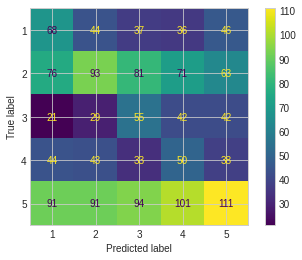

In [20]:
best_image_model.predict(image_X)
ans = best_image_model.predict(normalize(image_X,axis=0))
label = image_y
cm = confusion_matrix(ans, label)
ConfusionMatrixDisplay(cm, display_labels=[1,2,3,4,5]).plot()
# print(cm)
bin = dict({1: 0, 2: 0, 3: 0, 4: 0, 5: 0 })
for i in ans:
    bin[i] = bin[i] + 1
print(bin)

{1: 213, 2: 167, 3: 417, 4: 204, 5: 499}


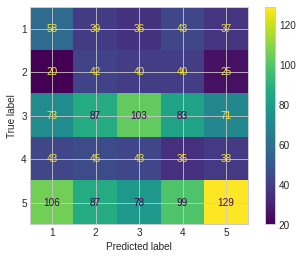

In [21]:
best_audio_model.predict(audio_X)
ans = best_audio_model.predict(normalize(audio_X,axis=0))
label = audio_y
cm = confusion_matrix(ans, label)
ConfusionMatrixDisplay(cm, display_labels=[1,2,3,4,5]).plot()
# print(cm)
bin = dict({1: 0, 2: 0, 3: 0, 4: 0, 5: 0 })
for i in ans:
    bin[i] = bin[i] + 1
print(bin)